In [80]:
import importlib
%matplotlib inline
import matplotlib.pyplot as plt 
import os, shutil, pathlib, PIL, sys
#Import local modules. 
#Most functions are incapsulated into independent modules so that the pipeline can be easily reproduced and reused in a single notebook with minimum code editing.
from Modules.Alignment import manage as align
from Modules.Morphing import manage as morph
from PIL import Image, ImageEnhance
import cv2

# Data cleaning and preprocessing

In [81]:
import pandas as pd

In [82]:
df = pd.read_csv('CXR8/Data_Entry_2017_v2020.csv')

In [83]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [84]:
df.loc[~df['Finding Labels'].str.contains('\|')]['Finding Labels'].unique()

array(['Cardiomegaly', 'No Finding', 'Hernia', 'Infiltration', 'Nodule',
       'Emphysema', 'Effusion', 'Atelectasis', 'Mass', 'Pneumothorax',
       'Pleural_Thickening', 'Fibrosis', 'Consolidation', 'Edema',
       'Pneumonia'], dtype=object)

In [85]:
# drop mixed phenotypes
df.drop(df.loc[df['Finding Labels'].str.contains('\|')].index, inplace = True) 

In [86]:
# Group patient ages
def groupAge(age):
    if age in range(0,19):
        return '0-18'
    if age in range(19,45):
        return '19-44'
    if age in range(45,65):
        return '45-64'
    if age in range(65,85):
        return '65-85'
    return '85+'
df['Patient Age Group'] = df['Patient Age'].apply(lambda x: groupAge(x))
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Patient Age Group
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143,45-64
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171,65-85
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168,65-85
5,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,0.168,65-85
7,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,0.168,65-85


In [88]:
df.drop(df.loc[df['View Position']!='PA'].index, inplace = True) 
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Patient Age Group
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143,45-64
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171,65-85
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168,65-85
5,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,0.168,65-85
7,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,0.168,65-85


In [89]:
# Get all data ready for pipeline
pipelinedData = []
for phenotype, df_phenotype in df.groupby('Finding Labels'):
    for gender, df_gender in df_phenotype.groupby('Patient Gender'):
        for ageGroup, df_ageGroup in df_gender.groupby('Patient Age Group'):
            data = (phenotype,gender,ageGroup,list(df_ageGroup['Image Index']))
            pipelinedData.append(data)

In [ ]:
#Create working directory
try:
    os.mkdir('WorkingDirectory')
except OSError:
    pass
#sort images into categories
for x in pipelinedData:
    os.mkdir(f'WorkingDirectory/{x[0]}_{x[1]}_{x[2]}')
    for y in x[3]:
        shutil.copy(f'CXR8/images/{y}', f'WorkingDirectory/{x[0]}_{x[1]}_{x[2]}/{y}')


# Auto crop and align images

In [ ]:
# A trained model for lungs detection is loaded
# The model draws bounding boxes around lungs so that we can crop and resize the lungs areas to get them roughly pre-aligned

::::::: 1024:1024 
<class 'numpy.ndarray'>




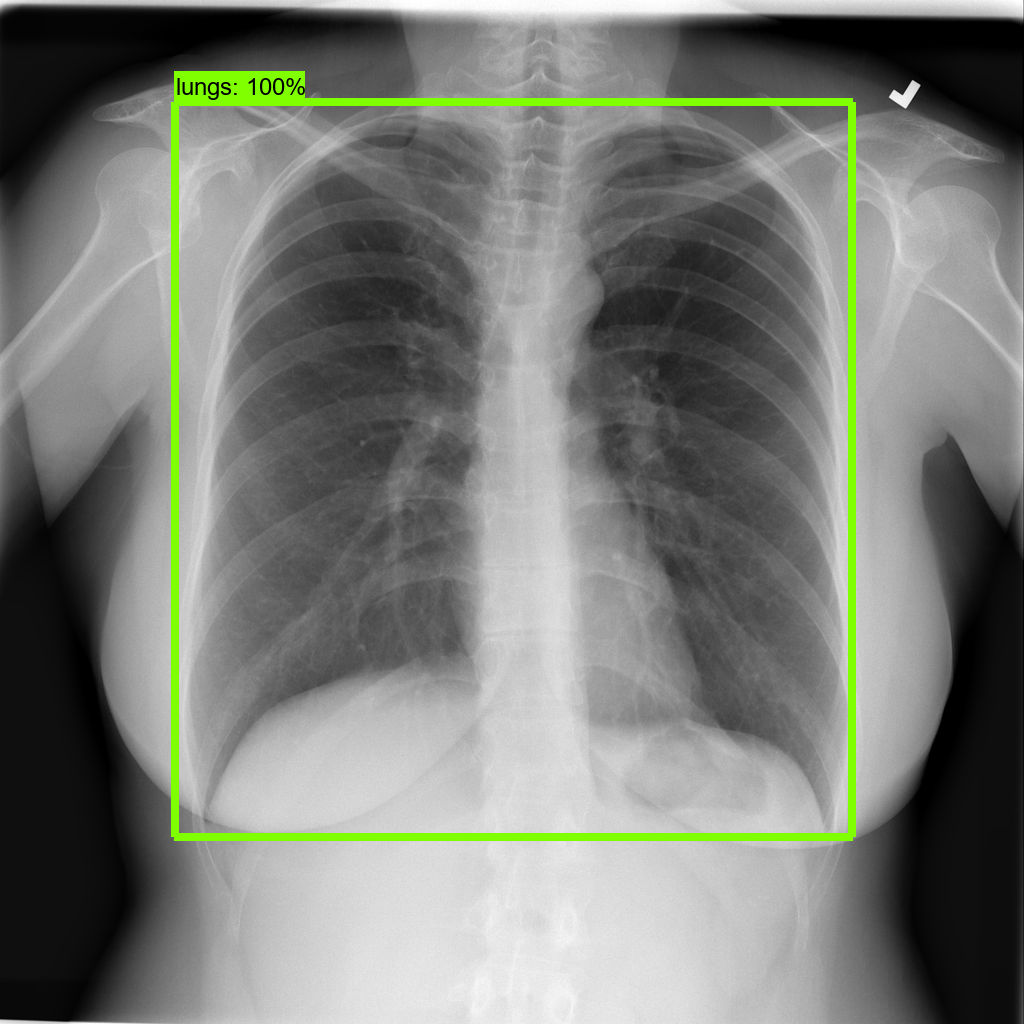

In [10]:
# Test the model on a few images:
align.inference_on_image_with_display('CXR8/images/00006700_008.png')

In [ ]:
align.inference_on_image_with_display('CXR8/images/00006695_001.png')

In [9]:
#
counter = 0
for x in pipelinedData:
    if counter > 100:
        os.mkdir(f'WorkingDirectory/aligned/{x[0]}_{x[1]}_{x[2]}')
        align.crop_and_resize_all(f'WorkingDirectory/images/{x[0]}_{x[1]}_{x[2]}',f'WorkingDirectory/aligned/{x[0]}_{x[1]}_{x[2]}',1024,1024,className=1,minimumScore=0.99)

    counter += 1



Error with 00004404_005.png
Error with 00007624_036.png
Error with 00012834_007.png
Error with 00015024_003.png
Error with 00027465_008.png
Error with 00010007_121.png


In [ ]:
# Detect, crop, and align all provided images:
align.crop_and_resize_all('CropTestImages','CropTestOuput',1024,1024,className=1,minimumScore=0.99)

In [20]:
#align.inference_on_image_with_display('WorkingDirectory/images/Infiltration_F_0-18/00000975_001.png')
align.crop_and_resize('WorkingDirectory/images/Infiltration_F_0-18/00000975_001.png','test100.png',1024,1024)

error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-52oirelq\opencv\modules\highgui\src\window.cpp:376: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


In [30]:
align.get_inference_info('WorkingDirectory/images/Infiltration_F_0-18/00000975_001.png')

(array([118.37375, 115.19534, 663.8533 , 893.71155], dtype=float32),
 1,
 1.0,
 1024,
 1024)

ValueError: zero-size array to reduction operation minimum which has no identity

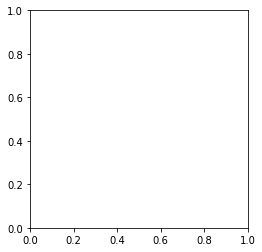

In [25]:

def crop_and_resize(input_path,output_path,width,height,className=1,minimumScore=0.9):
    info = align.get_inference_info(input_path)
    if info[1]==className and info[2] >= minimumScore:
        image_np=cv2.imread(input_path)
        crop_img = image_np[int(info[0][0]):int(info[0][2]), int(info[0][1]):int(info[0][3])]
        plt.imshow(crop_img)
        output = cv2.resize(crop_img, (width,height))
        cv2.imwrite(output_path,output) 
crop_and_resize('WorkingDirectory/images/Infiltration_F_0-18/00000975_001.png','test100.png',1024,1024)

In [29]:
importlib.reload(align)

Alignment Module Imported.


<module 'Modules.Alignment.manage' from 'D:\\Shodor\\project\\xray\\Modules\\Alignment\\manage.py'>

# Morph images

In [21]:
folderList = os.listdir('./WorkingDirectory/aligned')

Building working directories...
Loading images...
Preparing the mask image...
Generating an empty mask...
Validating image size...
New project successfully created.
DIR changed to  D:\Shodor\project\xray\Modules\Morphing\Morph
Executing Example.exe...
Executable finished.
DIR changed back to  D:\Shodor\project\xray
Result image:
D:\Shodor\project\xray\Modules\Morphing/Morph/UserFiles/OutputImages/output.png


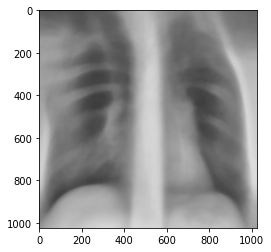

In [117]:
LIMIT = 200
FOLDERLIMIT = 100

foldercount = 0
for folder in folderList:

    if not (folder.endswith('No_Finding_F_19-44')):
        continue

    if foldercount >= FOLDERLIMIT:
        shutil.rmtree('./WorkingDirectory/tmp')
        break

    try:
        os.mkdir('WorkingDirectory/tmp')
    except OSError:
        pass

    images = os.listdir(f'./WorkingDirectory/aligned/{folder}')
    counter = 0
    for file in images:
        if counter >= LIMIT:
            break
        if file.endswith('.png'):
            #im = Image.open(os.path.join(f'./WorkingDirectory/aligned/{folder}',file))
            #ImageEnhance.Contrast(im).enhance(1.0).save(os.path.join('./WorkingDirectory/tmp',file))
            im = cv2.imread(os.path.join(f'./WorkingDirectory/aligned/{folder}',file))
            im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
            clahe = cv2.createCLAHE(clipLimit=5.0,tileGridSize=(8,8))#cl=2
            cl_img = clahe.apply(im)
            cv2.imwrite(os.path.join('./WorkingDirectory/tmp',file),cl_img)
        counter += 1
    morph.build_new_project(f'D:/Shodor/project/xray/WorkingDirectory/tmp')
    morph.start_project()
    try:
        morph.getOutputImage(f'./WorkingDirectory/{folder}.png')
    except:
        print('Error with output image')
        pass
    shutil.rmtree('./WorkingDirectory/tmp')
    foldercount += 1

In [33]:
os.chdir('D:/Shodor/project/xray')

In [51]:
!dir

 Volume in drive D is Extreme SSD
 Volume Serial Number is E8DD-5003

 Directory of D:\Shodor\project\xray

10/24/2020  11:18 PM    <DIR>          .
10/24/2020  11:18 PM    <DIR>          ..
11/29/2020  11:15 AM               167 .gitignore
10/24/2020  11:18 PM               121 .gitmodules
10/24/2020  11:18 PM               486 debug.log
12/04/2020  01:38 AM           969,768 MainApp.ipynb
10/17/2020  06:48 PM                 0 README.md
10/24/2020  11:18 PM    <DIR>          .ipynb_checkpoints
10/17/2020  11:41 PM    <DIR>          Modules
11/29/2020  12:23 AM    <DIR>          CXR8
11/29/2020  10:40 AM    <DIR>          WorkingDirectory
12/03/2020  09:03 PM           521,641 original-image.png
12/03/2020  08:55 PM           262,111 less-contrast-image.png
12/03/2020  09:03 PM           593,818 more-contrast-image.png
               8 File(s)      2,348,112 bytes
               6 Dir(s)  147,796,787,200 bytes free


In [ ]:
morph.start_project()

In [ ]:
morph.viewOutputImage()

In [ ]:
morph.getOutputImage('firstImage.png')

In [92]:
LIMIT = 200
FOLDERLIMIT = 1

foldercount = 0
for folder in folderList:
    if not (folder.endswith('19-44')):
        continue
    if foldercount >= FOLDERLIMIT:
        break
    try:
        os.mkdir('WorkingDirectory/tmp')
    except OSError:
        pass
    
    images = os.listdir(f'./WorkingDirectory/aligned/{folder}')
    counter = 0
    for file in images:
        if counter >= LIMIT:
            break
        if file.endswith('.png') and file:
            im = cv2.imread(os.path.join(f'./WorkingDirectory/aligned/{folder}',file))
            im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
            clahe = cv2.createCLAHE(clipLimit=100.0,tileGridSize=(8,8))
            cl_img = clahe.apply(im)
            cv2.imwrite(os.path.join('./WorkingDirectory/tmp',file),cl_img)
        counter += 1

    foldercount += 1